# 1) Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from math import ceil 
from pprint import pprint

import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.options.display.max_columns=100 
pd.options.display.max_rows=100

# 2) Funções

In [2]:
def find_missing_percent(data):
    """
    Retorna dataframe contendo o total de valores faltantes e porcentagem do total
    de valores faltantes da coluna.
    """
    miss_df = pd.DataFrame({'ColumnName':[],'TotalMissingVals':[],'PercentMissing':[]})
    for col in data.columns:
        sum_miss_val = data[col].isnull().sum()
        percent_miss_val = round((sum_miss_val/data.shape[0])*100,2)
        miss_df.loc[len(miss_df)] = dict(zip(miss_df.columns,[col,sum_miss_val,percent_miss_val]))
    return miss_df

In [3]:
def avalia_modelo(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test,y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'MSE:{mse} | RMSE:{rmse} | MAE:{mae} | R2:{r2}')
    
    return rmse

# 3) Processamento dos Dados

Os valores outliers já foram tratados na etapa de limpeza dos dados, agora cabe lidar com os valores nulos para viabilizar a utilização dos modelos de Machine Learning

In [4]:
df1 = pd.read_csv('base_limpa1.csv', index_col=0)
df2 = pd.read_csv('base_limpa2.csv', index_col=0)

df = pd.concat([df1, df2])

In [5]:
# Mantendo somente os pedidos que não foram cancelados para que possamos analisar os tempos de entrega
# São pouco mais de 30k em 350k de linhas disponíveis
df = df[~df['order_status'].eq('CANCELED')]

df.reset_index(drop=True, inplace=True)

In [6]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['order_moment_accepted'] = pd.to_datetime(df['order_moment_accepted'])

# Criando colunas para facilitar análises
# Colunas para o tempo de realização do pedido
df['minute_rea'] = df['order_date'].dt.minute
df['hour_rea'] = df['order_date'].dt.hour
df['day_rea'] = df['order_date'].dt.day
df['month_rea'] = df['order_date'].dt.month
df['year_rea'] = df['order_date'].dt.year
df['weekday_rea'] = df['order_date'].dt.weekday # Domingo é 0

# Colunas para o tempo de aceitação do pedido
df['minute_ac'] = df['order_moment_accepted'].dt.minute
df['hour_ac'] = df['order_moment_accepted'].dt.hour
df['day_ac'] = df['order_moment_accepted'].dt.day
df['month_ac'] = df['order_moment_accepted'].dt.month
df['year_ac'] = df['order_moment_accepted'].dt.year
df['weekday_ac'] = df['order_moment_accepted'].dt.weekday # Domingo é 0

# Tempo para aceitar o pedido
df['dif_tempo'] = df['order_moment_accepted'] - df['order_date']
df['min_para_aceitar'] = df['dif_tempo'].apply(lambda x: round(x.total_seconds() / 60 ,2))

df.drop(columns=['order_date', 'order_moment_accepted', 'dif_tempo'], axis=1, inplace=True)

In [7]:
find_missing_percent(df)

,ColumnName,TotalMissingVals,PercentMissing
0,hub_name,0,0.00
1,hub_city,0,0.00
2,hub_state,0,0.00
3,store_name,0,0.00
4,store_segment,0,0.00
5,store_plan_price,77525,23.12
6,driver_modal,5697,1.70
7,driver_type,5697,1.70
8,delivery_distance_meters,2611,0.78
9,delivery_status,2582,0.77


In [8]:
# removendo colunas que não serão úteis para prever o tempo de entrega, já que não teremos informações delas no momento do pedido
col_del = ['order_status', 'payment_status', 'delivery_status', 'order_moment_ready', 'order_moment_collected',
       'order_moment_in_expedition', 'order_moment_delivering',
       'order_moment_finished', 'order_metric_collected_time',
       'order_metric_paused_time', 'order_metric_production_time',
       'order_metric_walking_time', 'order_metric_expediton_speed_time',
       'order_metric_transit_time']

# tirando os anoS já que só possuo dados de 2021
col_del = col_del + ['year_rea', 'year_ac'] 
df.drop(col_del, axis=1, inplace=True)

In [9]:
linhas_antes = df.shape[0]
# Removendo pedidos sem o tempo de entrega 'order_metric_cycle_time'
df = df[~df['order_metric_cycle_time'].isnull()]

In [10]:
# Preenchendo valores faltantes do store_plan_price para poder dividir em colunas por OneHotEncoding
df['store_plan_price'].fillna(-1, inplace=True)

# REMOVENDO TODAS AS LINHAS COM VALORES NULOS 
df.dropna(axis=0, inplace=True)


df.reset_index(drop=True, inplace=True)

linhas_depois = df.shape[0]
print(f'apaguei {linhas_antes - linhas_depois} linhas e restam {round(100*linhas_depois / linhas_antes)}% do df')

apaguei 8851 linhas e restam 97% do df


In [11]:
# Vamos listar as features que vamos utilizar
#input_cols_categoric = ['hub_state', 'store_segment', 'channel_type', 'driver_modal', 'store_plan_price']
#input_cols_numeric = ['delivery_distance_meters', 'payment_amount', 'payment_fee', 'order_amount',  
#                    'minute_rea', 'hour_rea', 'day_rea', 'month_rea',
#                     'weekday_rea', 'minute_ac', 'hour_ac','day_ac', 'month_ac', 
#                     'weekday_ac', 'min_para_aceitar']

input_cols_categoric = ['hub_state','channel_type', 'store_plan_price']
input_cols_numeric = ['delivery_distance_meters', 'payment_amount', 'payment_fee', 'order_amount',  
                    'minute_rea', 'hour_rea', 'day_rea', 'month_rea',
                     'weekday_rea', 'minute_ac', 'hour_ac','day_ac', 'month_ac', 
                     'weekday_ac', 'min_para_aceitar']

features = input_cols_categoric + input_cols_numeric

target = 'order_metric_cycle_time'

In [12]:
# Dividindo os dados antes de qualquer pré-processamento
X = df[features]  
y = df[target]  

# Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=999
)

In [13]:
# Tratando as variáveis categóricas 

encoder = ce.OneHotEncoder(cols=input_cols_categoric, handle_unknown='ignore')

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

# Modelos

## RandomForestRegressor

### Modelo 1

In [14]:
reg_RF1 = RandomForestRegressor(n_estimators=500, 
                                max_depth=None, 
                                max_features='sqrt',
                                random_state=0)

kfold  = KFold(n_splits=3, shuffle=True)
result = cross_val_score(reg_RF1, X_train, y_train, cv = kfold, scoring='neg_root_mean_squared_error')

In [15]:
print(f'K-Fold RMSE Scores: {result}')
print(f'Mean RMSE for Cross-Validation K-Fold: {result.mean()}')

K-Fold RMSE Scores: [-10.80816943 -10.80735915 -10.8032005 ]
Mean RMSE for Cross-Validation K-Fold: -10.806243026427973


In [16]:
reg_RF1.fit(X_train, y_train)
reg_RF1_rmse = avalia_modelo(reg_RF1, X_test, y_test)

MSE:111.30802799828442 | RMSE:10.550261987187067 | MAE:8.244994240548987 | R2:0.31510433549538686


com *100k* dados:

    K-Fold RMSE Scores: [-10.89307441 -10.89038331 -10.90304294]
    
    Mean RMSE for Cross-Validation K-Fold: -10.895500220653789
    
    MSE:112.9366914664 | RMSE:10.62716761260497 | MAE:8.2810502 | R2:0.3230869567225756

com *200k* dados:

    K-Fold RMSE Scores: [-10.89275673 -10.81484423 -10.83509063]

    Mean RMSE for Cross-Validation K-Fold: -10.84756386480708

    MSE:113.1809906933 | RMSE:10.638655492744372 | MAE:8.32205905 | R2:0.30471678815575054


com *todos* os dados:

    K-Fold RMSE Scores: [-10.80816943 -10.80735915 -10.8032005 ]

    Mean RMSE for Cross-Validation K-Fold: -10.806243026427973

    MSE:111.30802799828442 | RMSE:10.550261987187067 | MAE:8.244994240548987 | R2:0.31510433549538686


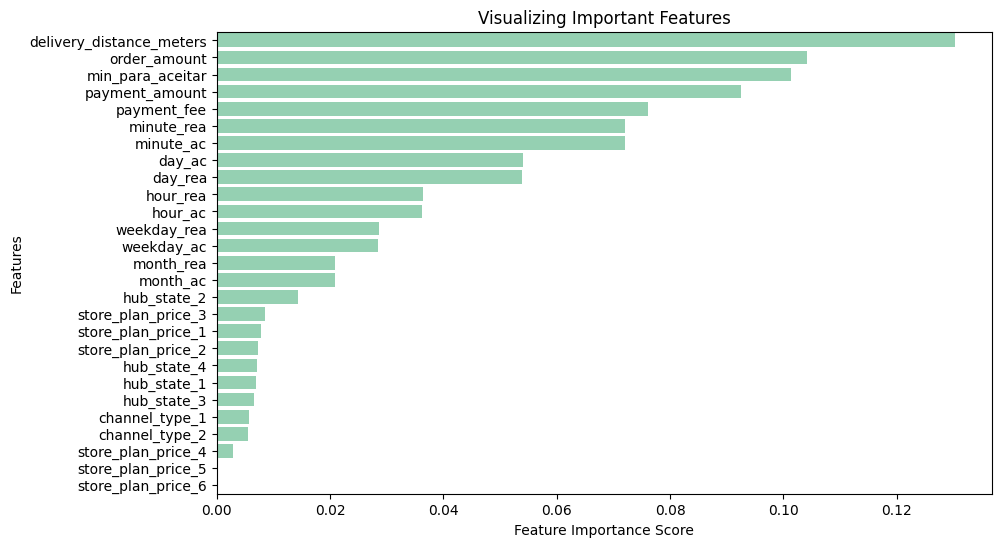

In [17]:
# FEATURE IMPORTANCE
feature_imp = pd.Series(reg_RF1.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.set_palette("mako_r")
# Creating a bar plot
_ = plt.figure(figsize=(10, 6))
_ = sns.barplot(x=feature_imp, y=feature_imp.index)
_ = plt.xlabel("Feature Importance Score")
_ = plt.ylabel("Features")
_ = plt.title("Visualizing Important Features")

### Modelo 2

In [18]:
reg_RF_basico = RandomForestRegressor(n_estimators=100,
                                random_state=0)

kfold  = KFold(n_splits=3, shuffle=True)
result = cross_val_score(reg_RF_basico, X_train, y_train, cv = kfold, scoring='neg_root_mean_squared_error')

In [19]:
print(f'K-Fold RMSE Scores: {result}')
print(f'Mean RMSE for Cross-Validation K-Fold: {result.mean()}')

K-Fold RMSE Scores: [-10.89028487 -10.87775099 -10.85335591]
Mean RMSE for Cross-Validation K-Fold: -10.873797256860316


In [20]:
reg_RF_basico.fit(X_train, y_train)
reg_RF_basico_rmse = avalia_modelo(reg_RF_basico, X_test, y_test)

MSE:110.77428564119847 | RMSE:10.524936372311164 | MAE:8.155452790882912 | R2:0.31838853550238244


com *100k* dados:

    K-Fold RMSE Scores: [-10.92481505 -11.00455842 -11.13886608]

    Mean RMSE for Cross-Validation K-Fold: -11.022746512908627
    
    MSE:113.16192522499999 | RMSE:10.637759408117857 | MAE:8.225695499999999 | R2:0.3217369643772794

com *200k* dados:

    K-Fold RMSE Scores: [-10.88115134 -10.9546771  -10.95387378]

    Mean RMSE for Cross-Validation K-Fold: -10.929900739123235

    MSE:113.31616119749998 | RMSE:10.645006397250308 | MAE:8.25489275 | R2:0.30388642095600193


com *todos* os dados:

    K-Fold RMSE Scores: [-10.89028487 -10.87775099 -10.85335591]

    Mean RMSE for Cross-Validation K-Fold: -10.873797256860316

    MSE:110.77428564119847 | RMSE:10.524936372311164 | MAE:8.155452790882912 | R2:0.31838853550238244


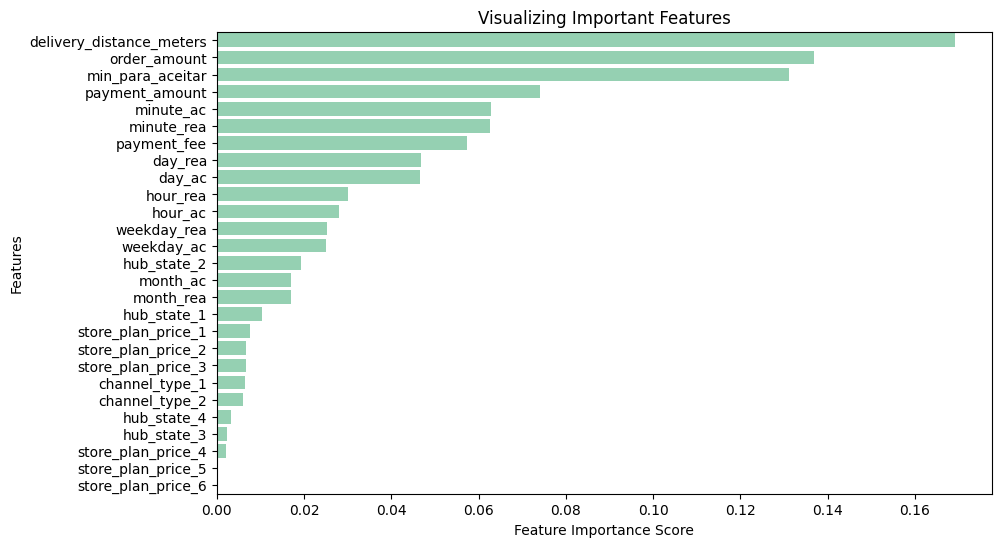

In [21]:
# FEATURE IMPORTANCE
feature_imp = pd.Series(reg_RF_basico.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.set_palette("mako_r")
# Creating a bar plot
_ = plt.figure(figsize=(10, 6))
_ = sns.barplot(x=feature_imp, y=feature_imp.index)
_ = plt.xlabel("Feature Importance Score")
_ = plt.ylabel("Features")
_ = plt.title("Visualizing Important Features")

## XGBRegressor

### Modelo 1

In [22]:
reg_XGB1 = XGBRegressor(booster='gbtree',
                        colsampl_bytree=0.8,
                         eval_metric='rmsle',
                         gamma=0.2,
                         learning_rate=0.2,
                         max_depth=10,
                         min_child_weight=3,
                         n_estimators=600,
                         n_jobs=-1,
                         objective='reg:squarederror',
                         random_state=0,
                         reg_alpha=0.3,
                         reg_lambda=0.1,
                         sumbsample=1)

kfold = KFold(n_splits=5, shuffle=True)
result = cross_val_score(reg_XGB1, X_train, y_train, cv = kfold, scoring='neg_root_mean_squared_error')

c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

In [23]:
print(f'K-Fold RMSE Scores: {result}')
print(f'Mean RMSE for Cross-Validation K-Fold: {result.mean()}')

K-Fold RMSE Scores: [-10.97945824 -10.99348853 -11.03205841 -10.96096134 -10.97075549]
Mean RMSE for Cross-Validation K-Fold: -10.987344401424776


In [24]:
reg_XGB1.fit(X_train, y_train)
reg_XGB1_rmse = avalia_modelo(reg_XGB1, X_test, y_test)

c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

MSE:117.07190732781051 | RMSE:10.81997723323901 | MAE:8.31786234249095 | R2:0.27963828659924594


com *100k* dados:

    K-Fold RMSE Scores: [-11.22250484 -11.08113463 -11.14003792 -11.0622696  -11.17448413]

    Mean RMSE for Cross-Validation K-Fold: -11.136086224700863
    
    MSE:116.97495086141092 | RMSE:10.815495867569407 | MAE:8.152014870071412 | R2:0.2988826842126646

com *200k* dados:

    K-Fold RMSE Scores: [-11.1130114  -11.04756688 -11.07748095 -11.00058548 -11.10145308]

    Mean RMSE for Cross-Validation K-Fold: -11.06801955700561

    MSE:118.13769661395524 | RMSE:10.869116643681549 | MAE:8.290597992682457 | R2:0.274267201245706


com *todos* os dados:

    K-Fold RMSE Scores: [-10.97945824 -10.99348853 -11.03205841 -10.96096134 -10.97075549]

    Mean RMSE for Cross-Validation K-Fold: -10.987344401424776

    MSE:117.07190732781051 | RMSE:10.81997723323901 | MAE:8.31786234249095 | R2:0.27963828659924594


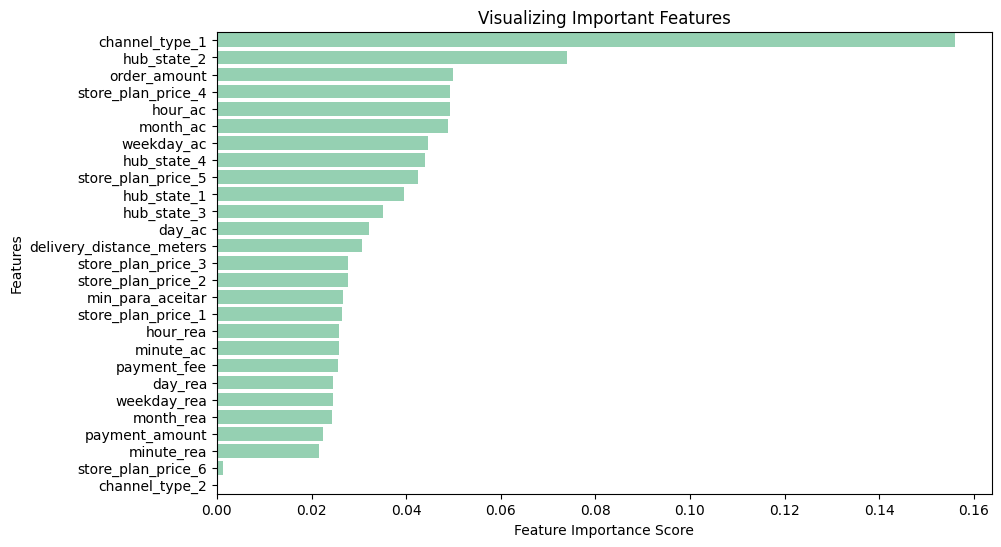

In [25]:
# FEATURE IMPORTANCE
feature_imp = pd.Series(reg_XGB1.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.set_palette("mako_r")
# Creating a bar plot
_ = plt.figure(figsize=(10, 6))
_ = sns.barplot(x=feature_imp, y=feature_imp.index)
_ = plt.xlabel("Feature Importance Score")
_ = plt.ylabel("Features")
_ = plt.title("Visualizing Important Features")

### Modelo 2

In [26]:
reg_XGB2 = XGBRegressor(learning_rate=0.05,
                         max_depth=10,
                         n_estimators=1000)

kfold = KFold(n_splits=5, shuffle=True)
result = cross_val_score(reg_XGB2, X_train, y_train, cv = kfold, scoring='neg_root_mean_squared_error')

c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

In [27]:
print(f'K-Fold RMSE Scores: {result}')
print(f'Mean RMSE for Cross-Validation K-Fold: {result.mean()}')

K-Fold RMSE Scores: [-10.765304   -10.72605616 -10.77752169 -10.83167184 -10.84360047]
Mean RMSE for Cross-Validation K-Fold: -10.788830833701727


In [28]:
reg_XGB2.fit(X_train, y_train)
reg_XGB2_rmse = avalia_modelo(reg_XGB2, X_test, y_test)

c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

MSE:114.53756926364679 | RMSE:10.702222631941778 | MAE:8.36738285965198 | R2:0.2952324641599291


com *100k* dados:

    K-Fold RMSE Scores: [-10.94196147 -10.78388379 -10.76225405 -10.78950588 -10.86723621]

    Mean RMSE for Cross-Validation K-Fold: -10.828968280329567
    
    MSE:112.07408890493411 | RMSE:10.58650503730736 | MAE:8.150653205919266 | R2:0.32825717126878884

com *200k* dados:

    K-Fold RMSE Scores: [-10.73490711 -10.78343742 -10.84589858 -10.78655771 -10.83936271]

    Mean RMSE for Cross-Validation K-Fold: -10.79803270642352

    MSE:114.92591734752645 | RMSE:10.720350616818763 | MAE:8.350188955664635 | R2:0.29399751276196284


com *todos* os dados:

    K-Fold RMSE Scores: [-10.765304   -10.72605616 -10.77752169 -10.83167184 -10.84360047]

    Mean RMSE for Cross-Validation K-Fold: -10.788830833701727
    
    MSE:114.53756926364679 | RMSE:10.702222631941778 | MAE:8.36738285965198 | R2:0.2952324641599291

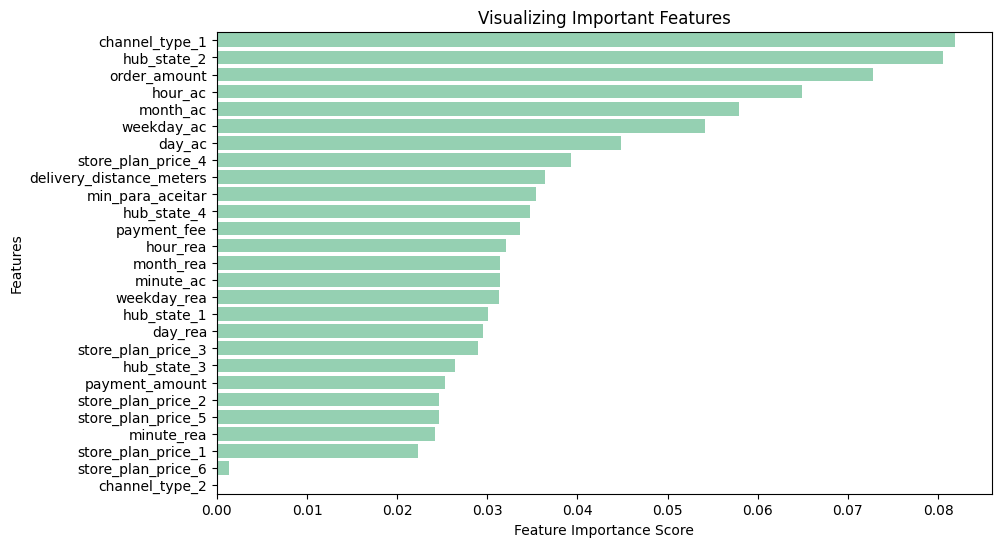

In [29]:
# FEATURE IMPORTANCE
feature_imp = pd.Series(reg_XGB2.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.set_palette("mako_r")
# Creating a bar plot
_ = plt.figure(figsize=(10, 6))
_ = sns.barplot(x=feature_imp, y=feature_imp.index)
_ = plt.xlabel("Feature Importance Score")
_ = plt.ylabel("Features")
_ = plt.title("Visualizing Important Features")

### Modelo 3 - Random

In [36]:
# Fazendo uma busca aleatória com parâmetros mais precisos
params = {
    'gamma': [0, 0.1, 0.2, 0.3],
    'learning_rate': [0.02, 0.05, 0.08, 0.01, 0.15, 0.2],
    'max_depth': [9, 10, 12],
    'n_estimators': [800, 900, 1000, 1100, 1200, 1300, 1500],
    'subsample': [0.5, 0.9, 1],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.2, 0.3, 0.4],
    'reg_lambda': [0, 0.1, 0.15]
}

XGB_model = XGBRegressor()

reg_XGB_random = RandomizedSearchCV(XGB_model, params, n_iter=50, cv=3, random_state=0)

model_random = reg_XGB_random.fit(X_train, y_train)

# print winning set of hyperparameters
pprint(model_random.best_estimator_.get_params())

c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

{'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.3,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 12,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 900,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'reg:squarederror',
 'random_state': None,
 'reg_alpha': 0.4,
 'reg_lambda': 0.1,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.9,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}


In [37]:
kfold = KFold(n_splits=5, shuffle=True)
result = cross_val_score(model_random.best_estimator_, X_train, y_train, cv = kfold, scoring='neg_root_mean_squared_error')

c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

In [38]:
print(f'K-Fold RMSE Scores: {result}')
print(f'Mean RMSE for Cross-Validation K-Fold: {result.mean()}')

K-Fold RMSE Scores: [-10.57076032 -10.55294203 -10.55683172 -10.53391578 -10.63360712]
Mean RMSE for Cross-Validation K-Fold: -10.569611393584532


In [39]:
reg_XGB_random_rmse = avalia_modelo(model_random.best_estimator_, X_test, y_test)

c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Apple\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version.

MSE:107.89092058360819 | RMSE:10.387055433740988 | MAE:7.973543560079087 | R2:0.3361303306149337


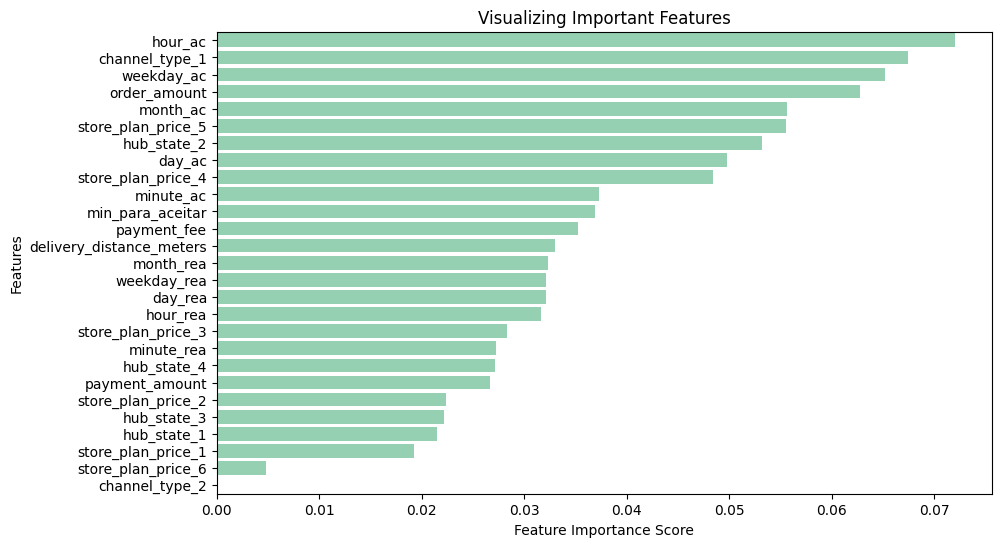

In [40]:
# FEATURE IMPORTANCE
feature_imp = pd.Series(model_random.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)

sns.set_palette("mako_r")
# Creating a bar plot
_ = plt.figure(figsize=(10, 6))
_ = sns.barplot(x=feature_imp, y=feature_imp.index)
_ = plt.xlabel("Feature Importance Score")
_ = plt.ylabel("Features")
_ = plt.title("Visualizing Important Features")

Melhor estimador com 200k dados

params =  ({'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.01,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 1300,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'reg:squarederror',
 'random_state': None,
 'reg_alpha': 0.4,
 'reg_lambda': 0.1,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': None})

    K-Fold RMSE Scores: [-10.96269192 -10.96789822 -10.90384607 -10.99989739 -11.01231018]

    Mean RMSE for Cross-Validation K-Fold: -10.969328757659643

    MSE:120.79645913990836 | RMSE:10.990744248680722 | MAE:8.665268977069855 | R2:0.25793413208584004



Melhor estimador com TODOS os dados

params = {'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.3,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 12,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 900,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'reg:squarederror',
 'random_state': None,
 'reg_alpha': 0.4,
 'reg_lambda': 0.1,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.9,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

    K-Fold RMSE Scores: [-10.57076032 -10.55294203 -10.55683172 -10.53391578 -10.63360712]

    Mean RMSE for Cross-Validation K-Fold: -10.569611393584532

    MSE:107.89092058360819 | RMSE:10.387055433740988 | MAE:7.973543560079087 | R2:0.3361303306149337

# Avaliações Métricas

In [34]:
#print(f'Modelo 1 RF: {reg_RF1_rmse}')
#print(f'Modelo 2 RF: {reg_RF_basico_rmse}')
print(f'Modelo 1 XGB: {reg_XGB1_rmse}')
print(f'Modelo 2 XGB: {reg_XGB2_rmse}')

Modelo 1 XGB: 10.81997723323901
Modelo 2 XGB: 10.702222631941778
